# 폐업 위험 가맹점 예측 (Risk Prediction)

## 목표
- 학습된 모델을 사용하여 현재 영업 중인 가맹점의 폐업 위험도 예측
- 고위험 가맹점 리스트 생성
- 위험 요인 분석

## 1. 환경 설정

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# 시각화 기본 설정 먼저 적용
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

# 한글 폰트 설정 (기본 설정 이후에 적용)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. 데이터 및 모델 로드

In [125]:
# Feature engineering 완료된 데이터 로드
data_path = Path('../data/processed/featured_data.csv')
df = pd.read_csv(data_path)

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Loaded data shape: (86590, 182)
Date range: 202301 ~ 202412


In [126]:
# 저장된 모델 및 feature 목록 로드
model_dir = Path('../models')

# 최적 모델 로드
with open(model_dir / 'xgboost_best.pkl', 'rb') as f:
    model = pickle.load(f)
print("✓ Model loaded: XGBoost (Tuned)")

# Feature 목록 로드
with open(model_dir / 'feature_cols.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
print(f"✓ Features loaded: {len(feature_cols)} features")

# 모델 성능 확인
import json
with open(model_dir / 'final_results.json', 'r') as f:
    results = json.load(f)
print(f"\nModel Performance (Test Set):")
print(f"  ROC-AUC: {results['test_roc_auc']:.4f}")
print(f"  Precision: {results['test_precision']:.4f}")
print(f"  Recall: {results['test_recall']:.4f}")
print(f"  F1 Score: {results['test_f1']:.4f}")

✓ Model loaded: XGBoost (Tuned)
✓ Features loaded: 168 features

Model Performance (Test Set):
  ROC-AUC: 0.9260
  Precision: 0.7517
  Recall: 0.3784
  F1 Score: 0.5034


In [127]:
# Feature 한글명 매핑 로드
with open(model_dir.parent / 'data/processed/feature_name_mapping.json', 'r', encoding='utf-8') as f:
    name_mapping = json.load(f)

def translate_feature_name(feature_name):
    """Feature 이름을 한글명으로 변환"""
    # 원본 컬럼인 경우
    if feature_name in name_mapping['원본 컬럼']:
        return name_mapping['원본 컬럼'][feature_name]
    
    # 고객 특성 파생변수
    if feature_name in name_mapping['고객 특성 파생변수']:
        return name_mapping['고객 특성 파생변수'][feature_name]
    
    # 복합 지표
    if feature_name in name_mapping['복합 지표']:
        return name_mapping['복합 지표'][feature_name]
    
    # 날짜 특성
    if feature_name in name_mapping['날짜 특성']:
        return name_mapping['날짜 특성'][feature_name]
    
    # 타겟 변수
    if feature_name in name_mapping['타겟 변수']:
        return name_mapping['타겟 변수'][feature_name]
    
    # 시계열 파생 변수 (예: MCT_OPE_MS_CN_lag_1m)
    for base_name, kr_name in name_mapping['원본 컬럼'].items():
        if feature_name.startswith(base_name):
            suffix = feature_name[len(base_name):]
            if suffix in name_mapping['시계열 suffix 설명']:
                return kr_name + ' ' + name_mapping['시계열 suffix 설명'][suffix]
    
    # 매핑 없는 경우 원본 이름 반환
    return feature_name

# 전체 feature 한글명 딕셔너리 생성
feature_names_kr = {feat: translate_feature_name(feat) for feat in feature_cols}

print("✓ Feature name mapping loaded")
print(f"  Sample mappings:")
for i, (eng, kor) in enumerate(list(feature_names_kr.items())[:5]):
    print(f"    {eng:30s} -> {kor}")

✓ Feature name mapping loaded
  Sample mappings:
    MCT_OPE_MS_CN                  -> 운영개월수
    RC_M1_SAA                      -> 매출금액
    RC_M1_TO_UE_CT                 -> 매출건수
    RC_M1_UE_CUS_CN                -> 고객수
    RC_M1_AV_NP_AT                 -> 객단가


## 3. 현재 영업 중인 가맹점 필터링

In [128]:
# 최신 월(2024년 12월) 데이터에서 영업 중인 가맹점 추출
latest_month = df['TA_YM'].max()
print(f"Latest month: {latest_month}")

# 최신 월 데이터
df_latest = df[df['TA_YM'] == latest_month].copy()
print(f"\nTotal merchants in {latest_month}: {len(df_latest):,}")

# 영업 중인 가맹점 (is_closed = 0)
df_active = df_latest[df_latest['is_closed'] == 0].copy()
print(f"Active merchants: {len(df_active):,}")
print(f"Closed merchants: {len(df_latest) - len(df_active):,}")

Latest month: 202412

Total merchants in 202412: 4,155
Active merchants: 4,058
Closed merchants: 97


## 4. 폐업 위험도 예측

In [129]:
# Feature 준비 (학습 시와 동일한 전처리)
X_active = df_active[feature_cols].copy()

# 결측값 처리 (중앙값으로 대체)
X_active = X_active.fillna(X_active.median())

print(f"Prediction features shape: {X_active.shape}")
print(f"Missing values: {X_active.isnull().sum().sum()}")

Prediction features shape: (4058, 168)
Missing values: 0


In [130]:
# 폐업 확률 예측
closure_probabilities = model.predict_proba(X_active)[:, 1]

# 결과 DataFrame 생성
df_risk = df_active[['ENCODED_MCT', 'TA_YM']].copy()
df_risk['closure_probability'] = closure_probabilities

# 위험도 등급 부여
df_risk['risk_level'] = pd.cut(
    closure_probabilities,
    bins=[0, 0.1, 0.3, 0.5, 0.7, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

print("✓ Prediction completed")
print(f"\nProbability statistics:")
print(df_risk['closure_probability'].describe())

✓ Prediction completed

Probability statistics:
count    4058.000000
mean        0.015392
std         0.052198
min         0.000011
25%         0.000576
50%         0.002288
75%         0.009200
max         0.969049
Name: closure_probability, dtype: float64


## 5. 위험도 분포 분석

Risk Level Distribution:
Very Low    : 3,921 (96.62%)
Low         :   106 ( 2.61%)
Medium      :    23 ( 0.57%)
High        :     5 ( 0.12%)
Very High   :     3 ( 0.07%)


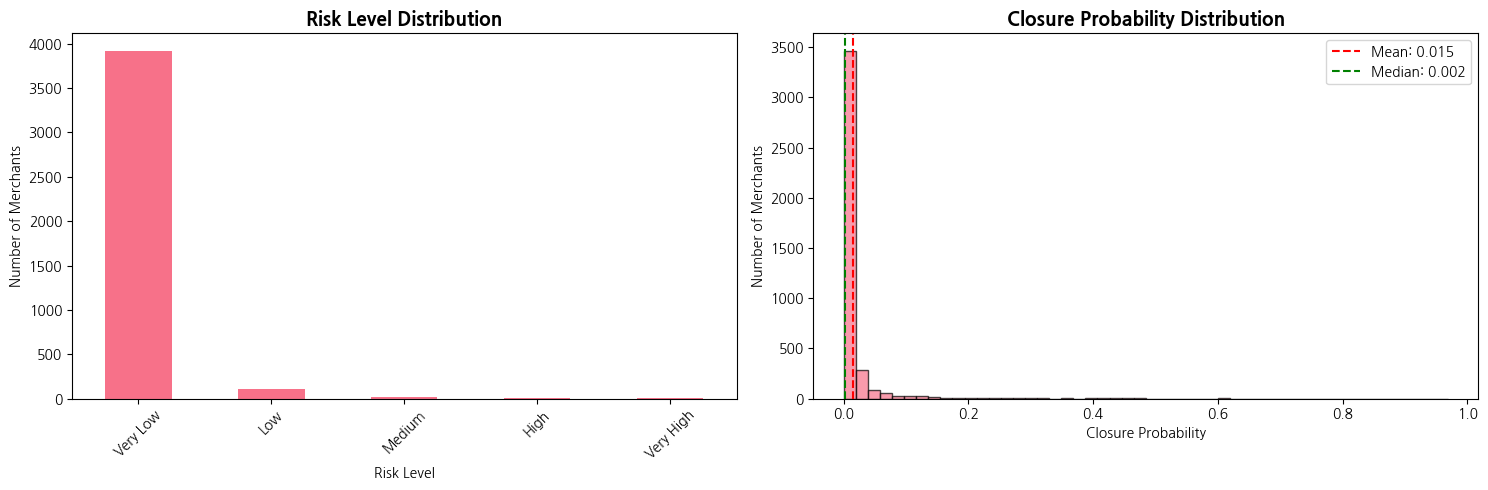

In [131]:
# 위험도 등급별 분포
print("Risk Level Distribution:")
print("=" * 60)
risk_dist = df_risk['risk_level'].value_counts().sort_index()
for level, count in risk_dist.items():
    pct = count / len(df_risk) * 100
    print(f"{level:12s}: {count:5,} ({pct:5.2f}%)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 위험도 등급 분포
risk_dist.plot(kind='bar', ax=axes[0])
axes[0].set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Number of Merchants')
axes[0].tick_params(axis='x', rotation=45)

# 2. 폐업 확률 히스토그램
axes[1].hist(closure_probabilities, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Closure Probability Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Closure Probability')
axes[1].set_ylabel('Number of Merchants')
axes[1].axvline(closure_probabilities.mean(), color='red', linestyle='--',
                label=f'Mean: {closure_probabilities.mean():.3f}')
axes[1].axvline(np.median(closure_probabilities), color='green', linestyle='--',
                label=f'Median: {np.median(closure_probabilities):.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. 고위험 가맹점 리스트

In [132]:
# 상위 100개 고위험 가맹점
high_risk_merchants = df_risk.nlargest(100, 'closure_probability').copy()

print("Top 100 High-Risk Merchants:")
print("=" * 80)
print(f"Probability range: {high_risk_merchants['closure_probability'].min():.4f} ~ "
      f"{high_risk_merchants['closure_probability'].max():.4f}")
print(f"\nRisk level distribution:")
print(high_risk_merchants['risk_level'].value_counts())

# 샘플 출력
print("\nTop 20 High-Risk Merchants:")
display(high_risk_merchants.head(20))

Top 100 High-Risk Merchants:
Probability range: 0.1353 ~ 0.9690

Risk level distribution:
risk_level
Low          69
Medium       23
High          5
Very High     3
Very Low      0
Name: count, dtype: int64

Top 20 High-Risk Merchants:


,ENCODED_MCT,TA_YM,closure_probability,risk_level
13003,2541119B6A,202412,0.969049,Very High
15683,2D3C8D6F8A,202412,0.888173,Very High
11691,216590EA3B,202412,0.859485,Very High
48067,8C6E34858D,202412,0.614686,High
2694,0806C51324,202412,0.607656,High
74346,DD4FCA5BE6,202412,0.607269,High
33720,5FE5C42B70,202412,0.591511,High
28310,50BD9E37F2,202412,0.512033,High
71,003473B465,202412,0.487628,Medium
72343,D6BA8B518B,202412,0.484088,Medium


## 7. 고위험 가맹점 특성 분석 (전체 비교)

In [133]:
# 고위험 가맹점 (확률 > 0.5)과 저위험 가맹점 비교
high_risk_idx = df_risk[df_risk['closure_probability'] > 0.5].index
low_risk_idx = df_risk[df_risk['closure_probability'] < 0.1].index

print(f"High risk merchants (prob > 0.5): {len(high_risk_idx):,}")
print(f"Low risk merchants (prob < 0.1): {len(low_risk_idx):,}")

# 주요 feature 비교
if len(high_risk_idx) > 0 and len(low_risk_idx) > 0:
    # Feature importance 기반 상위 10개 feature 선택
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'feature_kr': [feature_names_kr[f] for f in feature_cols],  # 한글명 추가
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance.head(10)['feature'].tolist()
    top_features_kr = feature_importance.head(10)['feature_kr'].tolist()
    
    # 비교 테이블
    comparison = pd.DataFrame({
        '항목명': top_features_kr,
        '고위험 평균': X_active.loc[high_risk_idx, top_features].mean().values,
        '저위험 평균': X_active.loc[low_risk_idx, top_features].mean().values
    })
    comparison['차이 (%)'] = (
        (comparison['고위험 평균'] - comparison['저위험 평균']) / 
        comparison['저위험 평균'] * 100
    )
    
    print("\nTop 10 Features Comparison (High Risk vs Low Risk):")
    display(comparison.round(2))

High risk merchants (prob > 0.5): 8
Low risk merchants (prob < 0.1): 3,921

Top 10 Features Comparison (High Risk vs Low Risk):


,항목명,고위험 평균,저위험 평균,차이 (%)
0,운영개월수 (1개월 전),4.50,3.44,30.65
1,운영개월수,4.38,3.42,27.92
2,매출금액 (6개월 평균),4.94,3.51,40.61
3,매출금액 (12개월 평균),4.92,3.51,40.43
4,재방문 고객 비중 (3개월),24.31,25.21,-3.58
5,고객수 (12개월 표준편차),0.34,0.36,-7.66
6,여성 20대이하 비중,17.97,10.37,73.32
7,재방문 고객 비중 (12개월),22.25,24.87,-10.53
8,고객수 (12개월 평균),4.54,3.49,30.24
9,매출금액 (12개월 표준편차),0.35,0.47,-25.78


## 8. SHAP 분석: 고위험 가맹점의 위험 요인

In [134]:
import shap

# SHAP explainer 생성
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(model)

# 고위험 가맹점 (top 20) SHAP 값 계산
top_20_idx = high_risk_merchants.head(20).index
X_top20 = X_active.loc[top_20_idx]

print("Calculating SHAP values for top 20 high-risk merchants...")
shap_values = explainer.shap_values(X_top20)

print("✓ SHAP analysis completed")

Creating SHAP explainer...
Calculating SHAP values for top 20 high-risk merchants...
✓ SHAP analysis completed


In [135]:
# 각 가맹점의 주요 위험 요인 분석
def analyze_risk_factors(merchant_idx, shap_idx, top_n=10):
    """개별 가맹점의 주요 위험 요인 분석"""
    merchant_id = df_risk.loc[merchant_idx, 'ENCODED_MCT']
    risk_prob = df_risk.loc[merchant_idx, 'closure_probability']
    
    # SHAP 값 추출
    shap_contribution = pd.DataFrame({
        'feature': feature_cols,
        'feature_kr': [feature_names_kr[f] for f in feature_cols],  # 한글명 추가
        'shap_value': shap_values[shap_idx],
        'feature_value': X_active.loc[merchant_idx].values
    })
    
    # 절대값 기준 상위 N개 feature
    shap_contribution['abs_shap'] = shap_contribution['shap_value'].abs()
    top_factors = shap_contribution.nlargest(top_n, 'abs_shap')
    
    return merchant_id, risk_prob, top_factors

# Top 5 고위험 가맹점 분석
print("=" * 100)
print("TOP 5 HIGH-RISK MERCHANTS - RISK FACTORS ANALYSIS")
print("=" * 100)

for i in range(min(5, len(high_risk_merchants))):
    merchant_idx = high_risk_merchants.index[i]
    merchant_id, risk_prob, factors = analyze_risk_factors(merchant_idx, i, top_n=10)
    
    print(f"\n[Rank {i+1}] Merchant ID: {merchant_id}")
    print(f"Closure Probability: {risk_prob:.2%}")
    print(f"\nTop 10 Risk Factors:")
    print("-" * 100)
    
    for j, (_, row) in enumerate(factors.iterrows(), 1):
        impact = "↑ 위험 증가" if row['shap_value'] > 0 else "↓ 위험 감소"
        print(f"{j:2d}. {row['feature_kr']:40s} | 값: {row['feature_value']:8.2f} | "
              f"SHAP: {row['shap_value']:+7.4f} | {impact}")
    print("-" * 100)

TOP 5 HIGH-RISK MERCHANTS - RISK FACTORS ANALYSIS

[Rank 1] Merchant ID: 2541119B6A
Closure Probability: 96.90%

Top 10 Risk Factors:
----------------------------------------------------------------------------------------------------
 1. 동일상권 매출 순위                               | 값:    90.70 | SHAP: +1.6891 | ↑ 위험 증가
 2. 동일업종 매출건수 비율                             | 값:     0.00 | SHAP: +0.4844 | ↑ 위험 증가
 3. 재방문 고객 비중 (12개월 변화량)                     | 값:    69.28 | SHAP: +0.3473 | ↑ 위험 증가
 4. 남성 20대이하 비중                              | 값:     9.89 | SHAP: +0.3290 | ↑ 위험 증가
 5. 동일업종 해지 가맹점 비중                           | 값:    16.20 | SHAP: +0.3133 | ↑ 위험 증가
 6. 운영개월수                                    | 값:     3.00 | SHAP: +0.2450 | ↑ 위험 증가
 7. 동일상권 해지 가맹점 비중                           | 값:     9.40 | SHAP: +0.2119 | ↑ 위험 증가
 8. 건강도 지수 (12개월)                            | 값:     0.59 | SHAP: -0.2019 | ↓ 위험 감소
 9. 동일업종 매출 순위                               | 값:    95.80 | SHAP: +0.1878 | ↑ 위험 증가


SHAP Waterfall Plots for Top 3 High-Risk Merchants:

[Rank 1] 2541119B6A (Risk: 96.90%)


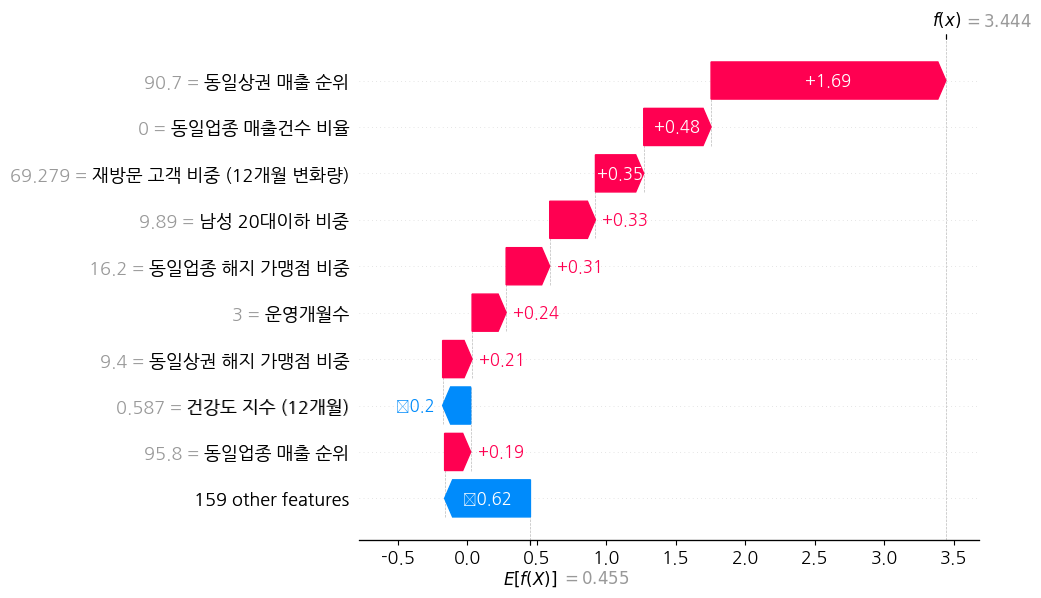


[Rank 2] 2D3C8D6F8A (Risk: 88.82%)


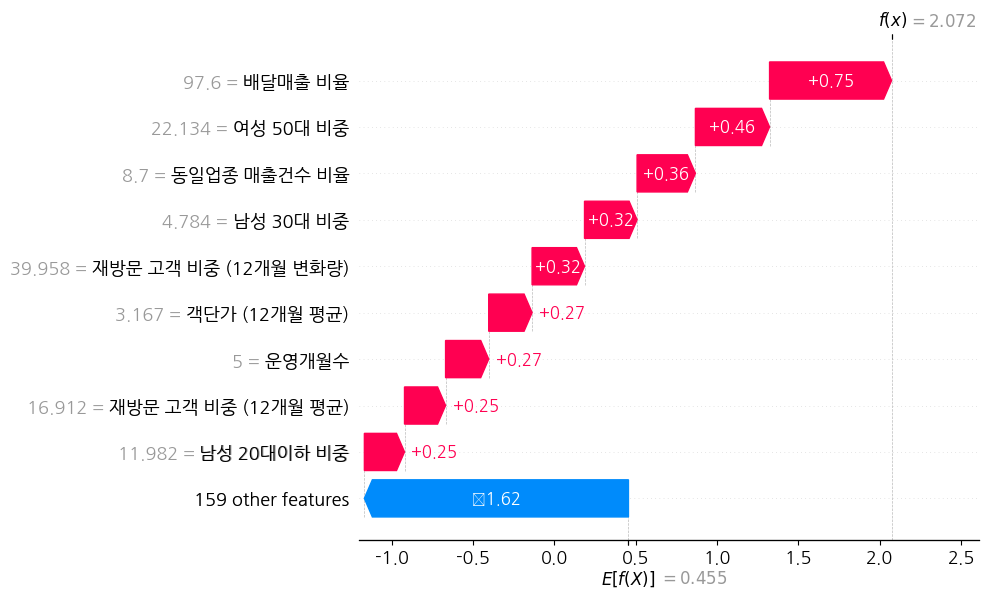


[Rank 3] 216590EA3B (Risk: 85.95%)


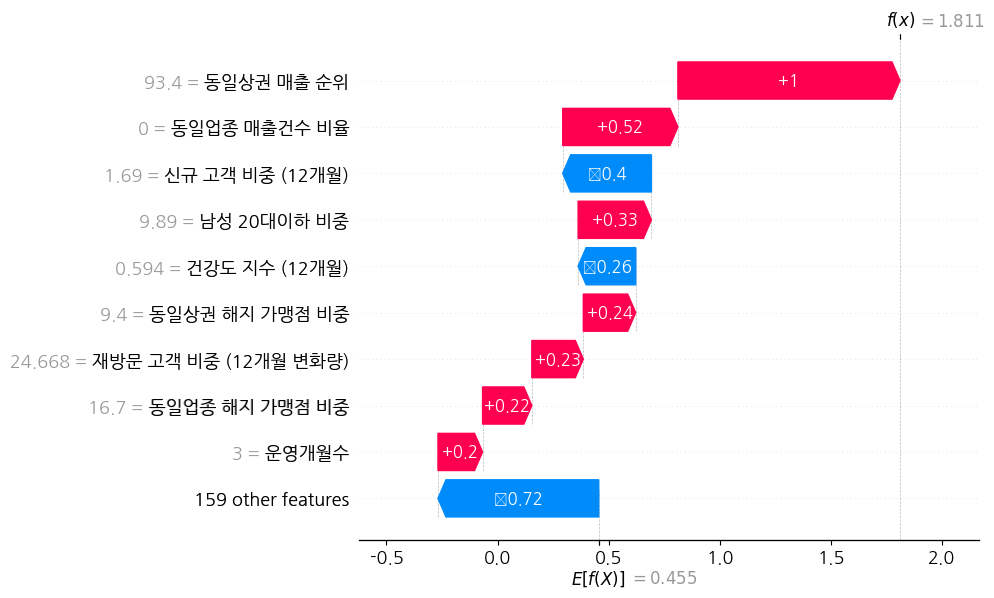

In [136]:
# SHAP 시각화: Top 3 고위험 가맹점
print("SHAP Waterfall Plots for Top 3 High-Risk Merchants:")
print("=" * 80)

# 한글 feature 이름 리스트
feature_names_kr_list = [feature_names_kr[f] for f in feature_cols]

for i in range(min(3, len(high_risk_merchants))):
    merchant_idx = high_risk_merchants.index[i]
    merchant_id = df_risk.loc[merchant_idx, 'ENCODED_MCT']
    risk_prob = df_risk.loc[merchant_idx, 'closure_probability']
    
    print(f"\n[Rank {i+1}] {merchant_id} (Risk: {risk_prob:.2%})")
    
    # 개별 waterfall plot (한글 feature 이름 사용)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value,
            data=X_top20.iloc[i].values,
            feature_names=feature_names_kr_list  # 한글 이름 사용
        ),
        max_display=10,
        show=True
    )

## 9. 고위험 가맹점 위험 요인 저장

In [137]:
# 고위험 가맹점 위험 요인 저장
risk_factors_list = []

for i in range(min(20, len(high_risk_merchants))):
    merchant_idx = high_risk_merchants.index[i]
    merchant_id, risk_prob, factors = analyze_risk_factors(merchant_idx, i, top_n=10)
    
    # 위험 요인 정리
    factors_dict = {
        'merchant_id': merchant_id,
        'closure_probability': float(risk_prob),
        'risk_factors': []
    }
    
    for _, row in factors.iterrows():
        factors_dict['risk_factors'].append({
            'feature': row['feature'],
            'feature_kr': row['feature_kr'],  # 한글명 추가
            'value': float(row['feature_value']),
            'shap_value': float(row['shap_value']),
            'impact': 'increase' if row['shap_value'] > 0 else 'decrease'
        })
    
    risk_factors_list.append(factors_dict)

# 데이터 저장 디렉토리
output_dir = Path('../data/predictions')
output_dir.mkdir(exist_ok=True)

# JSON 파일로 저장
import json
with open(output_dir / 'high_risk_factors.json', 'w', encoding='utf-8') as f:
    json.dump(risk_factors_list, f, indent=2, ensure_ascii=False)

print(f"✓ Saved: {output_dir / 'high_risk_factors.json'}")
print(f"  Analyzed {len(risk_factors_list)} high-risk merchants")

✓ Saved: ../data/predictions/high_risk_factors.json
  Analyzed 20 high-risk merchants


## 10. 전체 예측 결과 저장

In [138]:
# 전체 위험도 예측 결과 저장
df_risk_full = df_risk.sort_values('closure_probability', ascending=False)
df_risk_full.to_csv(output_dir / 'merchant_risk_scores.csv', index=False)
print(f"✓ Saved: {output_dir / 'merchant_risk_scores.csv'}")

# 고위험 가맹점 리스트 저장 (확률 > 0.5)
high_risk_list = df_risk[df_risk['closure_probability'] > 0.5].sort_values(
    'closure_probability', ascending=False
)
high_risk_list.to_csv(output_dir / 'high_risk_merchants.csv', index=False)
print(f"✓ Saved: {output_dir / 'high_risk_merchants.csv'}")
print(f"  High risk merchants: {len(high_risk_list):,}")

# 요약 통계 저장
summary = {
    'prediction_date': str(latest_month),
    'total_active_merchants': int(len(df_active)),
    'risk_distribution': {str(k): int(v) for k, v in risk_dist.items()},
    'high_risk_count': int(len(high_risk_list)),
    'probability_stats': {
        'mean': float(closure_probabilities.mean()),
        'median': float(np.median(closure_probabilities)),
        'std': float(closure_probabilities.std()),
        'min': float(closure_probabilities.min()),
        'max': float(closure_probabilities.max())
    }
}

import json
with open(output_dir / 'prediction_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"✓ Saved: {output_dir / 'prediction_summary.json'}")

✓ Saved: ../data/predictions/merchant_risk_scores.csv
✓ Saved: ../data/predictions/high_risk_merchants.csv
  High risk merchants: 8
✓ Saved: ../data/predictions/prediction_summary.json


## 11. 결론

### 완료된 작업
- ✅ 최신 데이터(2024년 12월)에서 영업 중인 가맹점 추출
- ✅ 학습된 모델로 폐업 확률 예측
- ✅ 위험도 등급 부여 (Very Low ~ Very High)
- ✅ **SHAP 분석을 통한 개별 가맹점 위험 요인 분석**
- ✅ 고위험 가맹점 특성 비교 분석
- ✅ 예측 결과 및 위험 요인 저장

### 저장된 파일
1. `merchant_risk_scores.csv`: 전체 가맹점 위험도 점수
2. `high_risk_merchants.csv`: 고위험 가맹점 리스트 (확률 > 0.5)
3. `high_risk_factors.json`: 개별 가맹점별 위험 요인 분석 (SHAP)
4. `prediction_summary.json`: 전체 예측 요약 통계

### 활용 방안
1. **고위험 가맹점 모니터링**: 확률 > 0.5인 가맹점 집중 관리
2. **조기 개입**: SHAP 분석 기반 위험 요인별 맞춤형 지원
3. **리스크 관리**: 여신 심사, 보증 한도 조정 등
4. **정기 업데이트**: 매월 새로운 데이터로 재예측

In [139]:
print("\n" + "="*80)
print("RISK PREDICTION COMPLETED")
print("="*80)
print(f"\nTotal Active Merchants: {len(df_active):,}")
print(f"High Risk Merchants (prob > 0.5): {len(high_risk_list):,}")
print(f"\nResults saved to: {output_dir}")


RISK PREDICTION COMPLETED

Total Active Merchants: 4,058
High Risk Merchants (prob > 0.5): 8

Results saved to: ../data/predictions
